Image Shape: torch.Size([1, 32, 32])
Training Set:   60000 samples
Validation Set:   10000 samples

Image Shape: torch.Size([1, 32, 32])
Training Set:   60000 samples
Validation Set:   10000 samples

Image Shape: torch.Size([1, 32, 32])
Training Set:   60000 samples
Validation Set:   10000 samples



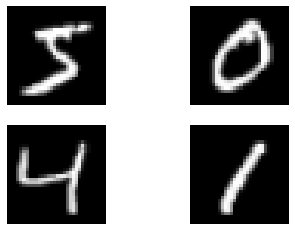

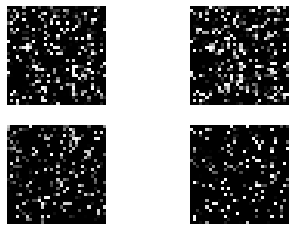

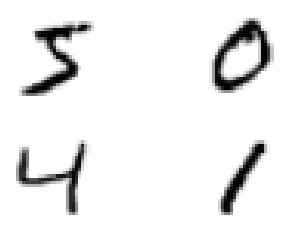

In [10]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image
import shutil
import random
import time
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
from torchvision import transforms, datasets
import tensorflow
import tarfile, requests, os

from utils import *
from Baseline_models import *
from dataloader import *
import torchvision.models as models
set_all_seed(5)

mnist_train_loader, mnist_val_loader = load_mnist()
permute_train_loader, permute_val_loader = load_permute_mnist()
# rotated_train_loader, rotated_val_loader = load_rotated_mnist()
inverted_train_loader, inverted_val_loader = load_inverted_mnist()

In [7]:
from torch.optim.sgd import SGD
from torch.optim.optimizer import required
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m,MaskedConv2d) or isinstance(m,MaskedMLP):
        m.reset_parameters()
        

model = MaskedResNet(1, MaskedBasicBlock, [2, 2, 2, 2]) #resnet18
# model = MaskedLeNet5()
# model = ResNet(1, BasicBlock, [2, 2, 2, 2]) #resnet18
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.apply(weight_reset)
summary(model, (1, 32, 32))


criterion = nn.CrossEntropyLoss()
optimizer1 = SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)

EWC = False
DynamicSparse = True

# task 1
task_1 = [mnist_train_loader, mnist_val_loader]
# task 2
task_2 = [permute_train_loader, permute_val_loader]
# task 3
task_3 = [inverted_train_loader, inverted_val_loader]

# # task 1
# task_3 = [domain1_train_loader, domain1_val_loader]
# # task 2
# task_2 = [domain2_train_loader, domain2_val_loader]
# # task 3
# task_1 = [domain3_train_loader, domain3_val_loader]




# task list
tasks = [task_1,task_2,task_3]
# tasks = [task_1]

#EWC
if EWC:
    fisher_dict = {}
    optpar_dict = {}
    ewc_lambda = 0.3

#DynamicSparse
if DynamicSparse:
    alpha = 1e-5

EPOCHS = 20

set_all_seed(5)

Bstep = BinaryStep.apply

# accs_SGD_A = []
# accs_SGD_B = []
# accs_SGD_C = []
# accs_SGD_D = []

# accs_EWC_A = []
# accs_EWC_B = []
# accs_EWC_C = []
# accs_EWC_D = []

accs_DS_A = []
accs_DS_B = []
accs_DS_C = []
accs_DS_D = []

#validation first
def train():
    
    #------------------------------------------------
    #            INITIAL VALIDATION b_i 
    #------------------------------------------------
    print('-'*85)
    B_i = []

    for id, task in enumerate(tasks):
        correct_val = 0
        Train_loader1, Val_loader1 = tasks[id] #data_loader of each task
        NB_TRAIN_EXAMPLES = len(Train_loader1.dataset)
        NB_VAL_EXAMPLES = len(Val_loader1.dataset)
        if device == "cuda":
            model.eval().cuda()

        with torch.no_grad():
            for inputs, labels in Val_loader1:
                # Load data to GPU.
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass.
                prediction = model(inputs)

                # Compute training accuracy.
                _, predicted = torch.max(prediction.data, 1)
                correct_val += (predicted == labels).sum().item()

            val_acc =  correct_val / NB_VAL_EXAMPLES
            B_i.append(val_acc)


        info = "[b_{}]: val-acc = {:0.6f}"
        print(info.format(id+1, val_acc))
    print('-'*85)
    

    
    R_ii = []
    R_li = [] # R_(i-1)i
    for id, task in enumerate(tasks):
        

        train_costs, val_costs = [], []


        optimizer = optimizer1
    
        Train_loader2, Val_loader2 = tasks[id] #data_loader of each task
        NB_TRAIN_EXAMPLES = len(Train_loader2.dataset)
        NB_VAL_EXAMPLES = len(Val_loader2.dataset)
        #------------------------------------------------
        #        BEFORE TASK VALIDATION R_(i-1)i
        #------------------------------------------------
        
        correct_val = 0

        if device == "cuda":
            model.eval().cuda()

        with torch.no_grad():
            for inputs, labels in Val_loader2:
                # Load data to GPU.
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass.
                prediction = model(inputs)

                # Compute training accuracy.
                _, predicted = torch.max(prediction.data, 1)
                correct_val += (predicted == labels).sum().item()

            val_acc =  correct_val / NB_VAL_EXAMPLES
            R_li.append(val_acc)


        print('-'*85)
        info = "[R_{}{}]: val-acc = {:0.6f}"
        print(info.format(id, id+1, val_acc))


        #------------------------------------------------
        #                 TRAINING
        #------------------------------------------------

        
        #Training phase.
        for epoch in range(EPOCHS):

            # Measure the elapsed time of each epoch
            t0_epoch, t0_batch = time.time(), time.time()


            train_loss, correct_train = 0, 0
            batch_loss, correct_batch, batch_counts = 0, 0, 0

            if device == "cuda":
                model.train().cuda()

            for step, (inputs, labels) in enumerate(Train_loader2):

                # Load data to GPU.
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients.
                optimizer.zero_grad()

                # Forward pass.
                prediction = model(inputs)

                # Compute the loss.
                loss = criterion(prediction, labels)
                
                # Dynamic sparse
                if DynamicSparse:
                    for layer in model.modules():
                        if isinstance(layer, MaskedMLP) or isinstance(layer, MaskedConv2d):
                            loss += alpha * torch.sum(torch.exp(-layer.threshold)) #
                
                
                # EWC
                if EWC:
                    for task in range(id):
                        for name, param in model.named_parameters():
                            fisher = fisher_dict[task][name]
                            optpar = optpar_dict[task][name]
                            loss += (fisher * (optpar - param).pow(2)).sum() * ewc_lambda 
                            #optpar=\theta_i, param=\theta_A*

                # Backward pass.
                loss.backward()

                #freeze trained parameters
                if DynamicSparse and id > 0:
                    for layer in model.modules():
                        if isinstance(layer, MaskedMLP) or isinstance(layer, MaskedConv2d):
                            layer.weight.grad.data[layer.task_mask.type(torch.bool)] = 0
#                             layer.threshold.grad.data[layer.task_mask.type(torch.bool)] = 0
                            if layer.bias is not None:
                                layer.bias.grad.data.fill_(0)
                        elif 'BatchNorm' in str(type(layer)):
                            # Set grads of batchnorm params to 0.
                            layer.weight.grad.data.fill_(0)
                            layer.bias.grad.data.fill_(0)

                # Optimize.
                optimizer.step()

                # Compute training accuracy.
                _, predicted = torch.max(prediction.data, 1)
                correct_train += (predicted == labels).sum().item()
                correct_batch += (predicted == labels).sum().item()

                # Compute batch loss.
                batch_loss += (loss.data.item() * inputs.shape[0])
                train_loss += (loss.data.item() * inputs.shape[0])



                batch_counts += inputs.shape[0]

            train_loss /= NB_TRAIN_EXAMPLES
            train_costs.append(train_loss)
            train_acc =  correct_train / NB_TRAIN_EXAMPLES

            time_elapsed = time.time() - t0_epoch
            

            #------------------------------------------------
            #           print_layer_keep_ratio
            #------------------------------------------------
            Conv_ratio=[] 
            MLP_ratio=[]  
            if DynamicSparse:
                total = 0. 
                keep = 0.
                for layer in model.modules():
                    if isinstance(layer, MaskedMLP):
                        abs_weight = torch.abs(layer.weight)
                        threshold = layer.threshold.view(abs_weight.shape[0], -1)
                        abs_weight = abs_weight-threshold
                        mask = layer.step(abs_weight)
                        ratio = torch.sum(mask) / mask.numel()
                        if epoch == EPOCHS-1:
                            MLP_ratio.append(ratio)
                        total += mask.numel()
                        keep += torch.sum(mask)
                    if isinstance(layer, MaskedConv2d):
                        weight_shape = layer.weight.shape 
                        threshold = layer.threshold.view(weight_shape[0], -1)
                        weight = torch.abs(layer.weight)
                        weight = weight.view(weight_shape[0], -1)
                        if epoch == EPOCHS-1:
                            weight_conv=weight
                        weight = weight - threshold
                        mask = layer.step(weight)
                        ratio = torch.sum(mask) / mask.numel()
                        if epoch == EPOCHS-1:
                            Conv_ratio.append(ratio)
                        total += mask.numel()
                        keep += torch.sum(mask) 
        
                info = "[Epoch{}/{}]:train-loss={:0.6f} |train-acc={:0.6f} |time_elapsed={:0.2f} |Model keep ratio={:0.4f}"
                print(info.format(epoch+1, EPOCHS, train_loss, train_acc, time_elapsed, keep/total))
                if epoch == EPOCHS-1:
                    print("MLP_ratio",MLP_ratio)       
                    print("Conv_ratio",Conv_ratio)  
                    Conv_weight.append(weight_conv)
            else:
                info = "[Epoch{}/{}]:train-loss={:0.6f} |train-acc={:0.6f} |time_elapsed={:0.2f}"
                print(info.format(epoch+1, EPOCHS, train_loss, train_acc, time_elapsed))
                
            #------------------------------------------------
            #            Epoch wise VALIDATION R_Ti 
            #------------------------------------------------

            for v_id, task in enumerate(tasks):
                correct_val = 0

                Train_loader3, Val_loader3 = tasks[v_id] #data_loader of each task
                NB_TRAIN_EXAMPLES = len(Train_loader3.dataset)
                NB_VAL_EXAMPLES = len(Val_loader3.dataset)
                if device == "cuda":
                    model.eval().cuda()

                with torch.no_grad():
                    for inputs, labels in Val_loader3:
                        # Load data to GPU.
                        inputs, labels = inputs.to(device), labels.to(device)

                        # Forward pass.
                        prediction = model(inputs)

                        # Compute training accuracy.
                        _, predicted = torch.max(prediction.data, 1)
                        correct_val += (predicted == labels).sum().item()

                    val_acc =  correct_val / NB_VAL_EXAMPLES
                    info = "id{},acc{}"
                    print(v_id, val_acc)
                
                if v_id == 0:
                    accs_DS_A.append(val_acc)
                if v_id == 1:
                    accs_DS_B.append(val_acc)
                if v_id == 2:
                    accs_DS_C.append(val_acc)
                if v_id == 3:
                    accs_DS_D.append(val_acc)
            
        #------------------------------------------------
        #           Update Dynamic task mask
        #------------------------------------------------
        if DynamicSparse:
            print('collecting task mask for task %s'%(id+1))
            for layer in model.modules():
                if isinstance(layer, MaskedMLP) or isinstance(layer, MaskedConv2d):
                    layer.task_mask = Bstep(layer.task_mask.to(device)+layer.mask.to(device))
                    layer.reset_threshold()
            
        #------------------------------------------------
        #                 Update EWC
        #------------------------------------------------

        if EWC:
            print('training with EWC')
            if device == "cuda":
                model.train().cuda()
            optimizer.zero_grad()

            # accumulating gradients for the trained dataset
            for step, (inputs, labels) in enumerate(Train_loader2):

                # Load data to GPU.
                inputs, labels = inputs.to(device), labels.to(device)
                prediction = model(inputs)
                loss = criterion(prediction, labels)

                # Backward pass.
                loss.backward()

            fisher_dict[id] = {}
            optpar_dict[id] = {}

            # gradients accumulated can be used to calculate fisher
            for name, param in model.named_parameters():
                optpar_dict[id][name] = param.data.clone() #optpar=\theta_i
                fisher_dict[id][name] = param.grad.data.clone().pow(2) #fisher=F_i
                
    #------------------------------------------------
    #            FINAL VALIDATION R_Ti 
    #------------------------------------------------

        
    R_Ti = []
    
    for id, task in enumerate(tasks):
        correct_val = 0
        
        Train_loader3, Val_loader3 = tasks[id] #data_loader of each task
        NB_TRAIN_EXAMPLES = len(Train_loader3.dataset)
        NB_VAL_EXAMPLES = len(Val_loader3.dataset)
        if device == "cuda":
            model.eval().cuda()

        with torch.no_grad():
            for inputs, labels in Val_loader3:
                # Load data to GPU.
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass.
                prediction = model(inputs)

                # Compute training accuracy.
                _, predicted = torch.max(prediction.data, 1)
                correct_val += (predicted == labels).sum().item()

            val_acc =  correct_val / NB_VAL_EXAMPLES
            R_Ti.append(val_acc)

        print('-'*85)
        info = "[R_T{}]: val-acc = {:0.6f}"
        print(info.format(id+1, val_acc))

    #------------------------------------------------
    #                 EVALUATION 
    #------------------------------------------------
    ACC = np.mean(R_Ti)
    BWT = 0
    for r_ti,r_ii in zip(R_Ti, R_ii):
        BWT += r_ti - r_ii
    BWT = BWT/(len(R_Ti)-1)
    FWT = 0
    for r_li,b_i in zip(R_li,B_i):
        FWT += r_li - b_i
    FWT = FWT/(len(B_i)-1)
    
    print('-'*85)
    info = "ACC = {}, BWT = {}, FWT = {}"
    print(info.format(ACC, BWT, FWT))
            

train()
print(Conv_weight)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
      MaskedConv2d-1           [-1, 64, 32, 32]             576
       BatchNorm2d-2           [-1, 64, 32, 32]             128
      MaskedConv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
      MaskedConv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
  MaskedBasicBlock-7           [-1, 64, 32, 32]               0
      MaskedConv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
     MaskedConv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
 MaskedBasicBlock-12           [-1, 64, 32, 32]               0
     MaskedConv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

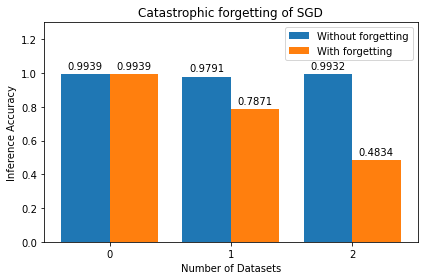

In [32]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
labels=["Learned 0 dataset","Learned 1 dataset","Learned 2 datasets"]
labels=labels[::-1]
SGD_MNIST=[0.483400,0.787100,0.993900]
RCL_MNIST=[0.980300,0.935600,0.985800]
RII_SGD_MNIST=[0.9932,0.9791,0.993900]
RII_RCL_MNIST=[0.9931,0.9614,0.985800]
RCL_DOMAINET=[0.640000,0.355000,0.510000]
SGD_DOMAINET=[0.247500,0.285000,0.570000]

x = np.arange(len(labels))  # the label locations
x=x[::-1]
width = 0.40  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, RII_SGD_MNIST, width, label='Without forgetting')
rects2 = ax.bar(x + width/2, SGD_MNIST, width, label='With forgetting')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Catastrophic forgetting of SGD')
ax.set_ylabel('Inference Accuracy')
ax.set_xlabel('Number of Datasets')
ax.set_ylim([0, 1.3])
ax.set_xticks(x)
# ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig('CF_SGD.png')
plt.show()

# MNIST strong domain 1e-5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(0, 61, 1)

accs_DS_A = [0.0952,0.9865, 0.9909, 0.9922, 0.9932, 0.9928, 0.9929, 0.9929, 0.9928, 0.9928, 0.993, 0.9931, 0.9931, 0.993, 0.9932, 0.9932, 0.9931, 0.9931, 0.9931, 0.9932, 0.9931, 0.9748, 0.9729, 0.9722, 0.9715, 0.9708, 0.9706, 0.9707, 0.9701, 0.97, 0.9696, 0.9694, 0.9692, 0.9691, 0.9689, 0.9688, 0.9686, 0.9682, 0.9681, 0.9676, 0.9675, 0.9819, 0.983, 0.9831, 0.983, 0.9826, 0.982, 0.9818, 0.9815, 0.9812, 0.9813, 0.9811, 0.9807, 0.9805, 0.9804, 0.9804, 0.9803, 0.9805, 0.9803, 0.9803, 0.9803]
accs_DS_B = [0.0967,0.0803, 0.0745, 0.077, 0.0723, 0.0716, 0.07, 0.071, 0.0711, 0.0718, 0.0715, 0.0714, 0.0716, 0.0718, 0.0719, 0.0717, 0.0715, 0.0711, 0.0714, 0.0713, 0.0715, 0.9431, 0.9516, 0.9558, 0.9572, 0.9573, 0.9573, 0.9581, 0.9588, 0.9597, 0.9598, 0.9601, 0.9606, 0.9605, 0.9607, 0.9608, 0.9609, 0.9612, 0.9613, 0.9615, 0.9614, 0.9485, 0.9488, 0.9474, 0.9464, 0.9458, 0.9452, 0.9451, 0.9444, 0.9437, 0.9427, 0.942, 0.9412, 0.94, 0.9398, 0.9392, 0.9381, 0.9378, 0.9366, 0.936, 0.9356]
accs_DS_C = [0.1138,0.4376, 0.4279, 0.4122, 0.3957, 0.3898, 0.3857, 0.3831, 0.3814, 0.3813, 0.3799, 0.3776, 0.3759, 0.3738, 0.3735, 0.376, 0.374, 0.3728, 0.3693, 0.3686, 0.3704, 0.2216, 0.2122, 0.2081, 0.2038, 0.2005, 0.1983, 0.1977, 0.1971, 0.1938, 0.1933, 0.1909, 0.1906, 0.1895, 0.1884, 0.1882, 0.1869, 0.1865, 0.186, 0.1853, 0.185, 0.9732, 0.979, 0.9804, 0.9826, 0.9832, 0.9832, 0.9835, 0.9835, 0.9837, 0.9838, 0.9838, 0.984, 0.9846, 0.9851, 0.9854, 0.9854, 0.9856, 0.9858, 0.9857, 0.9858]

accs_SGD_A = [0.0952,0.9875, 0.9911, 0.9923, 0.993, 0.9932, 0.9931, 0.993, 0.993, 0.9931, 0.9931, 0.9931, 0.9931, 0.9931, 0.9932, 0.9931, 0.993, 0.993, 0.993, 0.9931, 0.9932, 0.3405, 0.3634, 0.3913, 0.3861, 0.3851, 0.3842, 0.3843, 0.3836, 0.3832, 0.383, 0.3833, 0.3831, 0.3827, 0.3823, 0.3823, 0.3821, 0.3823, 0.3821, 0.3823, 0.3823, 0.539, 0.5295, 0.505, 0.5129, 0.5059, 0.5031, 0.5012, 0.4984, 0.4967, 0.495, 0.4938, 0.4921, 0.4908, 0.4896, 0.4887, 0.4872, 0.4859, 0.4851, 0.4843, 0.4834]
accs_SGD_B = [0.0967,0.0811, 0.0811, 0.0844, 0.0807, 0.0829, 0.0825, 0.0829, 0.0836, 0.0837, 0.0832, 0.0838, 0.0836, 0.0835, 0.083, 0.0834, 0.0835, 0.0836, 0.0837, 0.0836, 0.0837, 0.9645, 0.9738, 0.979, 0.9792, 0.979, 0.9789, 0.9788, 0.9787, 0.9787, 0.9787, 0.9788, 0.9789, 0.9789, 0.9789, 0.9789, 0.9789, 0.9791, 0.9791, 0.9792, 0.9791, 0.7669, 0.7845, 0.7793, 0.779, 0.7815, 0.782, 0.7826, 0.7839, 0.7845, 0.7846, 0.7852, 0.7853, 0.7857, 0.786, 0.7863, 0.7867, 0.7869, 0.7869, 0.787, 0.7871]
accs_SGD_C = [0.1138,0.4864, 0.4712, 0.4418, 0.4301, 0.4241, 0.4173, 0.4126, 0.408, 0.4051, 0.4027, 0.4007, 0.3977, 0.396, 0.3938, 0.392, 0.3907, 0.3894, 0.3879, 0.3871, 0.386, 0.1467, 0.1457, 0.146, 0.1454, 0.1426, 0.1418, 0.1421, 0.1417, 0.1414, 0.1412, 0.1408, 0.1401, 0.1398, 0.1399, 0.1397, 0.1395, 0.1389, 0.1386, 0.138, 0.1379, 0.9905, 0.9919, 0.9932, 0.9932, 0.9935, 0.9936, 0.9937, 0.9938, 0.9938, 0.9939, 0.994, 0.9939, 0.9939, 0.9939, 0.9939, 0.9939, 0.9939, 0.9939, 0.9939, 0.9939]


accs_EWC_A = [0.0952,0.9875, 0.9911, 0.9923, 0.993, 0.9932, 0.9931, 0.993, 0.993, 0.9931, 0.9931, 0.9931, 0.9931, 0.9931, 0.9932, 0.9931, 0.993, 0.993, 0.993, 0.9931, 0.9932, 0.426, 0.3832, 0.3847, 0.3731, 0.3701, 0.3678, 0.3661, 0.3645, 0.364, 0.3634, 0.3631, 0.3628, 0.3625, 0.3616, 0.3619, 0.3612, 0.3613, 0.3607, 0.3604, 0.3606, 0.4186, 0.3935, 0.3912, 0.389, 0.3854, 0.3828, 0.381, 0.3786, 0.3766, 0.3746, 0.373, 0.3717, 0.3708, 0.3691, 0.3678, 0.3662, 0.365, 0.3647, 0.3635, 0.3628]
accs_EWC_B = [0.0967,0.0811, 0.0811, 0.0844, 0.0807, 0.0829, 0.0825, 0.0829, 0.0836, 0.0837, 0.0832, 0.0838, 0.0836, 0.0835, 0.083, 0.0834, 0.0835, 0.0836, 0.0837, 0.0836, 0.0837, 0.9671, 0.975, 0.9793, 0.9804, 0.9802, 0.9803, 0.98, 0.98, 0.9799, 0.9797, 0.9796, 0.9796, 0.9797, 0.9797, 0.9797, 0.9798, 0.9797, 0.9797, 0.9798, 0.9798, 0.7729, 0.7718, 0.7675, 0.7717, 0.7739, 0.7738, 0.7739, 0.7742, 0.774, 0.7741, 0.7744, 0.7745, 0.7746, 0.7751, 0.7751, 0.7751, 0.7754, 0.7759, 0.7761, 0.7761]
accs_EWC_C = [0.1138,0.4864, 0.4712, 0.4418, 0.4301, 0.4241, 0.4173, 0.4126, 0.408, 0.4051, 0.4027, 0.4007, 0.3977, 0.396, 0.3938, 0.392, 0.3907, 0.3894, 0.3879, 0.3871, 0.386, 0.1774, 0.1696, 0.1753, 0.1711, 0.1686, 0.1681, 0.1678, 0.1672, 0.1678, 0.1672, 0.1664, 0.1665, 0.1664, 0.1662, 0.1657, 0.1654, 0.1649, 0.1647, 0.1642, 0.1641, 0.989, 0.9909, 0.9919, 0.9922, 0.9928, 0.9929, 0.9929, 0.9929, 0.9929, 0.9929, 0.9929, 0.993, 0.993, 0.993, 0.993, 0.993, 0.993, 0.9931, 0.9931, 0.9932]

accs_PackNet_A = [0.0952,0.9875, 0.9911, 0.9923, 0.993, 0.9932, 0.9931, 0.993, 0.993, 0.9931, 0.9931, 0.9903, 0.9922, 0.9923, 0.993, 0.993, 0.9932, 0.9933, 0.9934, 0.9935, 0.9935, 0.3461, 0.3494, 0.3778, 0.3792, 0.381, 0.3825, 0.3822, 0.3833, 0.3831, 0.3828, 0.4371, 0.4335, 0.43, 0.4275, 0.4259, 0.4248, 0.4237, 0.4225, 0.4216, 0.4209, 0.7174, 0.7003, 0.6654, 0.6471, 0.6375, 0.6298, 0.6253, 0.6199, 0.616, 0.6113, 0.6075, 0.6053, 0.6031, 0.6014, 0.5988, 0.5977, 0.5964, 0.5943, 0.5927, 0.591]
accs_PackNet_B = [0.0967,0.0811, 0.0811, 0.0844, 0.0807, 0.0829, 0.0825, 0.0829, 0.0836, 0.0837, 0.0832, 0.0859, 0.0884, 0.086, 0.0863, 0.0853, 0.0852, 0.0852, 0.0851, 0.0851, 0.0847, 0.9683, 0.9768, 0.9805, 0.9803, 0.9807, 0.9807, 0.9808, 0.9807, 0.9807, 0.9806, 0.9796, 0.9795, 0.9796, 0.9796, 0.9797, 0.9798, 0.9799, 0.98, 0.98, 0.9799, 0.9538, 0.9508, 0.9466, 0.9465, 0.9458, 0.945, 0.9443, 0.9432, 0.9426, 0.942, 0.9416, 0.9409, 0.9407, 0.9403, 0.9399, 0.94, 0.9398, 0.9396, 0.9389, 0.9389]
accs_PackNet_C = [0.1138,0.4864, 0.4712, 0.4418, 0.4301, 0.4241, 0.4173, 0.4126, 0.408, 0.4051, 0.4027, 0.5829, 0.5361, 0.5045, 0.4861, 0.4752, 0.4695, 0.4641, 0.4624, 0.4582, 0.4564, 0.1458, 0.1365, 0.1446, 0.144, 0.1448, 0.1442, 0.1436, 0.1429, 0.1428, 0.1425, 0.1442, 0.1442, 0.1454, 0.1457, 0.1455, 0.1455, 0.1456, 0.1446, 0.1445, 0.1444, 0.9883, 0.9923, 0.9921, 0.9924, 0.9924, 0.9926, 0.9926, 0.9926, 0.9926, 0.9927, 0.9927, 0.9927, 0.9927, 0.9927, 0.9927, 0.9927, 0.9927, 0.9927, 0.9927, 0.9927]

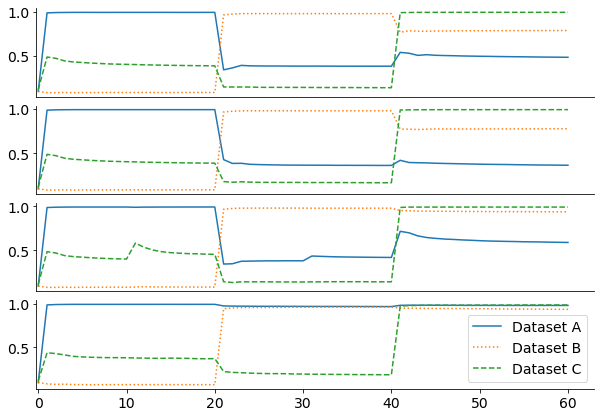

In [4]:
import numpy as np
import matplotlib.pyplot as plt


fig, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.1)
fig.set_size_inches(10, 7)
# two signals with a coherent part and a random part
ax1.plot(x,accs_SGD_A,label='Dataset A')
ax1.plot(x,accs_SGD_B,label='Dataset B', linestyle = 'dotted')
ax1.plot(x,accs_SGD_C,label='Dataset C', linestyle = 'dashed')
ax1.set_xlim(xmin=-0.2)
ax1.get_xaxis().set_visible(False)

# ax1.set_ylabel('SGD')


ax2.plot(x,accs_EWC_A,label='Dataset A')
ax2.plot(x,accs_EWC_B,label='Dataset B', linestyle = 'dotted')
ax2.plot(x,accs_EWC_C,label='Dataset C', linestyle = 'dashed')
ax2.set_xlim(xmin=-0.2)
ax2.get_xaxis().set_visible(False)

# ax2.set_ylabel('EWC')

ax3.plot(x,accs_PackNet_A,label='Dataset A')
ax3.plot(x,accs_PackNet_B,label='Dataset B', linestyle = 'dotted')
ax3.plot(x,accs_PackNet_C,label='Dataset C', linestyle = 'dashed')
ax3.set_xlim(xmin=-0.2)
# ax3.set_ylabel('PackNet')
ax3.get_xaxis().set_visible(False)

ax4.plot(x,accs_DS_A,label='Dataset A')
ax4.plot(x,accs_DS_B,label='Dataset B', linestyle = 'dotted')
ax4.plot(x,accs_DS_C,label='Dataset C', linestyle = 'dashed')
ax4.set_xlim(xmin=-0.2)
# ax4.set_ylabel('AdaptCL')
# ax4.get_xaxis().set_visible(False)

ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)
ax2.spines.right.set_visible(False)
ax2.spines.top.set_visible(False)
ax3.spines.right.set_visible(False)
ax3.spines.top.set_visible(False)
ax4.spines.right.set_visible(False)
ax4.spines.top.set_visible(False)

plt.legend()
plt.savefig('fig_strong1.png')
plt.show()

In [3]:
import matplotlib.pyplot as plt

# SMALL_SIZE = 16
# MEDIUM_SIZE = 20
# BIGGER_SIZE = 24

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

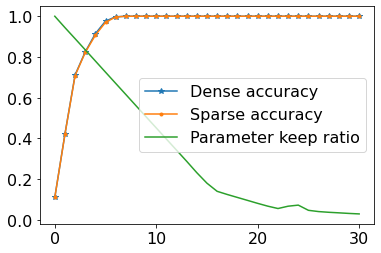

In [92]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots(1, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0)

# two signals with a coherent part and a random part
ax1.plot(new_result1dasgd,'*-',label='Dense accuracy')
ax1.plot(new_result1da[0:31],'.-',label='Sparse accuracy')
ax1.plot(new_result1[0:31],label='Parameter keep ratio')
# ax1.plot(new_result2,label='1e-5')
# ax1.plot(new_result3,label='1e-6')

# ax1.set_xlim(0, 5)
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Parameter keep ratio')
plt.legend(loc="center right")
plt.savefig('ablation5.png')
plt.show()

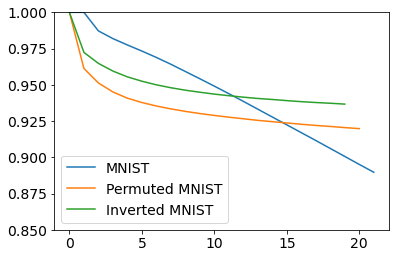

In [7]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots(1, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0)

# two signals with a coherent part and a random part
ax1.plot(r1,label='MNIST')
ax1.plot(r2,label='Permuted MNIST')
ax1.plot(r3,label='Inverted MNIST')

ax1.set_ylim(0.85, 1)
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Parameter keep ratio')
plt.legend()
plt.savefig('ablation00.png')
plt.show()

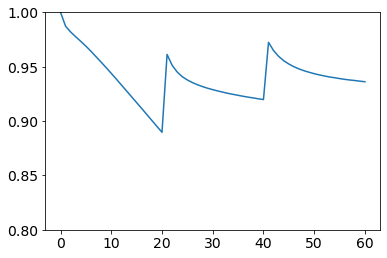

In [24]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots(1, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0)

# two signals with a coherent part and a random part
# ax1.plot(new_result3a,label='Accuracy')
ax1.plot(new_result)

ax1.set_ylim(0.8, 1)
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Parameter keep ratio')

plt.savefig('ablation0.png')
plt.show()

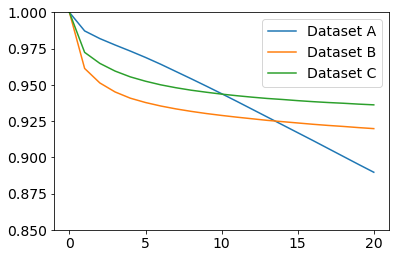

In [22]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots(1, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0)

# two signals with a coherent part and a random part
ax1.plot(r1,label='Dataset A')
ax1.plot(r2,label='Dataset B')
ax1.plot(r3,label='Dataset C')

ax1.set_ylim(0.85, 1)
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Parameter keep ratio')
plt.legend()
plt.savefig('ablation00.png')
plt.show()

In [67]:
import re
file = 'ratio_FQD4.txt'
f = open(file, 'r')
buff = f.read()
buff = buff.replace('\n',' ')
mark1="Model keep ratio="
mark2=" "

ratio = re.compile(mark1+'(.*?)'+mark2, re.S)
result = ratio.findall(buff)
new_result1f = [float(i) for i in result]

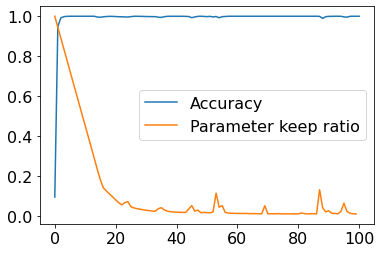

In [65]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots(1, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0)

# two signals with a coherent part and a random part
ax1.plot(new_result1a,label='Accuracy')

ax1.plot(new_result1,label='Parameter keep ratio')
# ax1.plot(new_result2,label='1e-5')
# ax1.plot(new_result3,label='1e-6')

# ax1.set_xlim(0, 5)
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Parameter keep ratio')
plt.legend()
plt.savefig('ablation1.png')
plt.show()

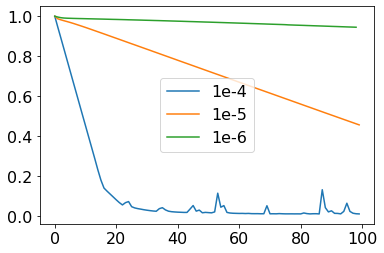

In [54]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots(1, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0)

# two signals with a coherent part and a random part
# ax1.plot(new_result3a,label='Accuracy')
ax1.plot(new_result1,label='1e-4')
ax1.plot(new_result2,label='1e-5')
ax1.plot(new_result3,label='1e-6')

# ax1.set_xlim(0, 5)
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Parameter keep ratio')
plt.legend(loc="center")
plt.savefig('ablation2.png')
plt.show()

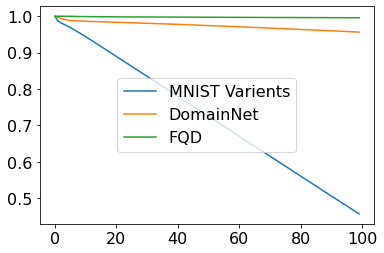

In [57]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots(1, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0)

# two signals with a coherent part and a random part
# ax1.plot(new_result3a,label='Accuracy')
ax1.plot(new_result2,label='MNIST Varients')
ax1.plot(new_result2d,label='DomainNet')
ax1.plot(new_result2f,label='FQD')

# ax1.set_xlim(0, 5)
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Parameter keep ratio')
plt.legend(loc="center")
plt.savefig('ablation3.png')
plt.show()

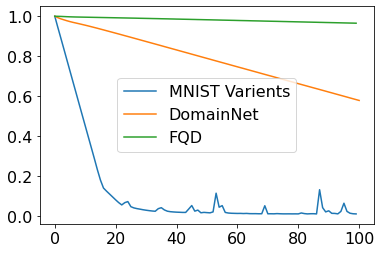

In [68]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots(1, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0)

# two signals with a coherent part and a random part
# ax1.plot(new_result3a,label='Accuracy')
ax1.plot(new_result1,label='MNIST Varients')
ax1.plot(new_result1d,label='DomainNet')
ax1.plot(new_result1f,label='FQD')

# ax1.set_xlim(0, 5)

plt.legend(loc="center")
plt.savefig('ablation4.png')
plt.show()